In [4]:
# -*- coding: utf-8 -*-
"""
Created on Wed Mar 29 11:04:41 2023
@author: 20192757
"""
import random
from pathlib import Path

import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from scipy.spatial.distance import directed_hausdorff
from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
import importlib
try: 
    importlib.reload(generators)
    importlib.reload(utils)
    importlib.reload(trainers)
    importlib.reload(u_net)
    print("libs reloaded")
except:
    import generators
    import trainers
    import utils
    import u_net
    print("libs imported")

libs imported


In [15]:
def dice_score(x, y, eps=1e-5):
    return (2*(x*y).sum()+eps) / ((x+y).sum()+eps)


device = "cuda" if torch.cuda.is_available() else "cpu"

# to ensure reproducible training/validation split
random.seed(42) 

# directorys with data and to stored training checkpoints
WORKING_DIR = Path(r"C:\Users\20182371\Documents\TUe\8DM20_CS_Medical_Imaging\DeepLearning_Project")

DATA_DIR = WORKING_DIR / "TrainingData" 
CHECKPOINTS_DIR = Path.cwd() / "segmentation_model_weights" 

 # hyperparameters
NO_VALIDATION_PATIENTS = 3
IMAGE_SIZE = [64, 64]

# find patient folders in training directory
# excluding hidden folders (start with .)
patients = [
    path
    for path in DATA_DIR.glob("*")
    if not any(part.startswith(".") for part in path.parts)
    ]

train_split = []
validation_split = []

for i in patients:
    if 'p107' in str(i):
        validation_split.append(i)
    elif 'p117' in str(i): 
        validation_split.append(i)
    elif 'p120' in str(i):
        validation_split.append(i)
    else:
        train_split.append(i)

# print(train_split)
# print(validation_split)

# split in training/validation after shuffling
partition = {
    "train": train_split,
    "validation": validation_split,
    }

# load validation data
valid_dataset = utils.ProstateMRDataset(partition["validation"], IMAGE_SIZE)
valid_dataloader = DataLoader(valid_dataset, batch_size=1)

# DICE and HD scores

In [ ]:
for number_fake in [0,4,8,12,16,20,24,28,32]:

    MODEL_DIR = CHECKPOINTS_DIR / "60_epochs_{x}_number_of_fake".format(x=number_fake) / "model.pth"

   

    unet_model = u_net.UNet(num_classes=1).to(device)
    unet_model.load_state_dict(torch.load(MODEL_DIR, map_location=device))
    unet_model.eval()

    # TODO
    # apply for all images and compute Dice score with ground-truth.
    # output .mhd images with the predicted segmentations
    with torch.no_grad():
        DiceScores = []
        HausdorffDist = []
        for image, target in tqdm(valid_dataloader):
            image = image.to(device)
            target = target[:,0:1].to(device)

            output = torch.sigmoid(unet_model(image))

            prediction = torch.round(output)

            dice = dice_score(prediction, target)
            #if all(v == 0 for v in target):
            DiceScores.append(dice.cpu().numpy())
            HausdorffDist.append(directed_hausdorff(prediction[0,0].cpu().numpy(), target[0,0].cpu().numpy())[0])
    
    RESULT_PATH = Path.cwd() / "results" 
    RESULT_PATH.mkdir(parents=True, exist_ok=True)
    with open(RESULT_PATH / "DICE_{x}.txt".format(x=number_fake), "w") as f:
        for s in DiceScores:
            f.write(str(s) +"\n")

    with open(RESULT_PATH / "HD_{x}.txt".format(x=number_fake), "w") as f:
        for s in HausdorffDist:
            f.write(str(s) +"\n")

# Segmentations 

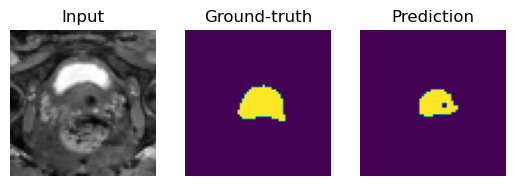

In [22]:
number_fake = 32
MODEL_DIR = CHECKPOINTS_DIR / f"60_epochs_{number_fake}_number_of_fake" / "model.pth"

unet_model = u_net.UNet(num_classes=1)
unet_model.load_state_dict(torch.load(MODEL_DIR, map_location='cpu'))
unet_model.eval()

with torch.no_grad():
    DiceScores = []
    HausdorffDist = []
    for i in range(len(valid_dataset)):
        predict_index = i
        (input, target) = valid_dataset[predict_index]
        output = torch.sigmoid(unet_model(input[np.newaxis, ...]))
        
        prediction = output
        prediction = prediction[0,0,:,:]
        target = target[0,:,:]
        
        dice = dice_score(prediction, target)
        #if all(v == 0 for v in target):
        DiceScores.append(dice.numpy())
        HausdorffDist.append(directed_hausdorff(prediction.numpy(), target.numpy())[0])
    
    (input, target) = valid_dataset[140]
    output = torch.sigmoid(unet_model(input[np.newaxis, ...]))
    prediction = torch.round(output)
    prediction = prediction[0,0,:,:]
    target = target[0,:,:]
    
    fig, ax = plt.subplots(1, 3)
    ax[0].imshow(input[0,:,:], cmap="gray")
    ax[0].set_title("Input")
    ax[0].axis("off")

    ax[1].imshow(target)
    ax[1].set_title("Ground-truth")
    ax[1].axis("off")

    ax[2].imshow(prediction)
    ax[2].set_title("Prediction")
    ax[2].axis("off")
    plt.show()